In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [2]:
KERNEL_TYPE = "se"
N_DIM = 4

In [3]:
DATA_DIR = Path().cwd().parent / "data"
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

df = pd.read_json(DATA_DIR / "benchmark_df.json")

se_data = df[df['kernel_type'] == KERNEL_TYPE].copy()

print(f"Loaded {len(se_data)} runs with SE kernel")
print(f"Unique combinations: {se_data.groupby(['acq_func', 'len_scale', 'n_dim']).ngroups}")
se_data

Loaded 45 runs with SE kernel
Unique combinations: 3


,acq_func,kernel_type,len_scale,n_dim,run_id,y_true_max,final_y_max,y_max_history,steps
0,expected_improvement,se,25,4,0,1.945998,0.876059,"[0.0682255191, 0.7479130559, 0.7479130559, 0.7...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
1,expected_improvement,se,25,4,1,2.292763,2.292763,"[0.7274658314, 2.2240682766, 2.2240682766, 2.2...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,expected_improvement,se,25,4,2,3.093659,2.491328,"[1.0713488401, 1.0713488401, 1.1987845835, 1.1...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
3,expected_improvement,se,25,4,3,2.208708,1.147857,"[0.6838809548, 0.6838809548, 0.6838809548, 0.6...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4,expected_improvement,se,25,4,4,1.732782,1.578258,"[0.5011471539, 0.5011471539, 0.5011471539, 1.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
5,expected_improvement,se,25,4,5,2.513983,2.167030,"[1.0601870284, 1.0601870284, 1.0601870284, 1.0...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
6,expected_improvement,se,25,4,6,2.525840,2.221760,"[1.3819091707, 1.3819091707, 1.3819091707, 1.4...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
7,expected_improvement,se,25,4,7,2.743816,2.192080,"[1.4376783562, 1.4376783562, 1.4376783562, 1.4...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
8,expected_improvement,se,25,4,8,3.216257,3.080099,"[3.0800994209, 3.0800994209, 3.0800994209, 3.0...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
9,expected_improvement,se,25,4,9,2.374261,1.981218,"[0.7135694762, 0.7135694762, 0.7135694762, 0.7...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."


In [4]:
se_data['regret'] = se_data.apply(lambda x: x['y_true_max'] - np.array(x['y_max_history']), axis=1)

regret_df = se_data[['acq_func', 'len_scale', 'n_dim', 'run_id', 'regret']].copy()
regret_df = regret_df.explode('regret').reset_index(drop=True) # Explode regret into new rows
regret_df['step'] = regret_df.groupby(['acq_func', 'len_scale', 'n_dim', 'run_id']).cumcount()

# Convert regret to numeric, from weird numpy types
regret_df['regret'] = pd.to_numeric(regret_df['regret'], errors='coerce')

regret_df = regret_df[regret_df["n_dim"] == N_DIM] # Filter for current dimension we care about

# Group by: acq_func (line), step (x).
# Aggregate: mean / std (y) and count for standard error calculation
regret_stats = regret_df.groupby(['acq_func', 'step'])['regret'].agg(['mean', 'std', 'count']).reset_index()

print(f"Created regret history for {len(regret_df)} data points")
print(f"Number of repetitions per setting: {regret_stats['count'].iloc[0]}")
regret_stats

Created regret history for 990 data points
Number of repetitions per setting: 15


,acq_func,step,mean,std,count
0,expected_improvement,0,1.497378,0.586198,15
1,expected_improvement,1,1.327117,0.626834,15
2,expected_improvement,2,1.236631,0.646366,15
3,expected_improvement,3,1.094405,0.728032,15
4,expected_improvement,4,1.053282,0.710756,15
...,...,...,...,...,...
61,ves_ramp,17,0.582134,0.376026,15
62,ves_ramp,18,0.554846,0.403324,15
63,ves_ramp,19,0.554846,0.403324,15
64,ves_ramp,20,0.554598,0.402989,15


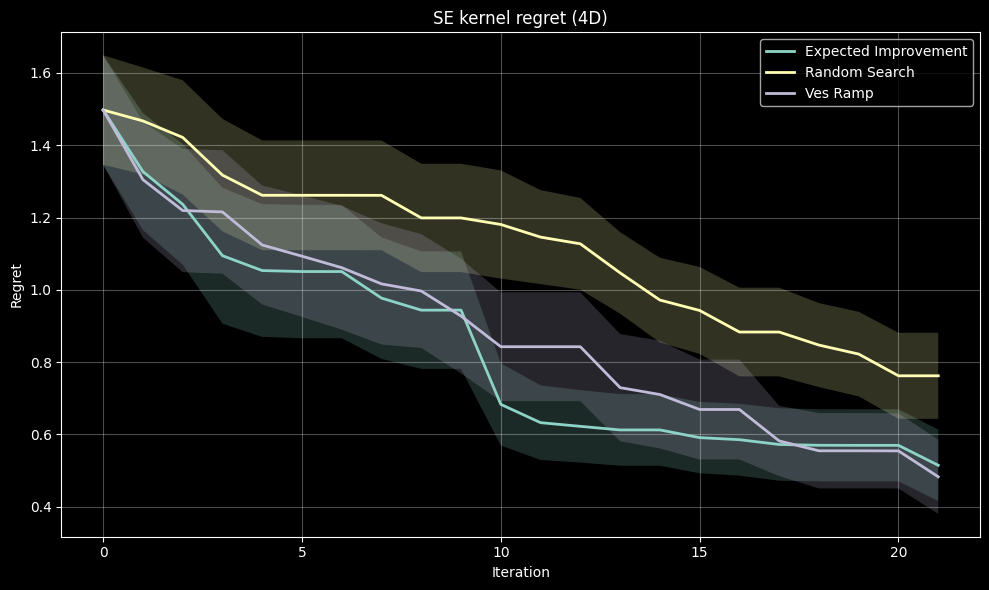

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

acq_funcs = regret_stats.acq_func.unique().tolist()
for method in acq_funcs:
    data = regret_stats[regret_stats['acq_func'] == method]
    ax.plot(data['step'], data['mean'], label=method.replace('_', ' ').title(), linewidth=2)
    standard_error = data['std'] / np.sqrt(data['count'])
    ax.fill_between(data['step'],
                    data['mean'] - standard_error,
                    data['mean'] + standard_error,
                    alpha=0.2)

ax.set_xlabel('Iteration')
ax.set_ylabel('Regret')
ax.set_title(f'{KERNEL_TYPE.upper()} kernel regret ({N_DIM}D)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()